#### [ --- DATABLOCK INITIALIZATION --- ]

**`--- IMAGE CLASSIFICATION ---`**
***
From dogs and cats => breeds

In [33]:
from fastai.vision.data import untar_data, URLs

# With an unfamiliar dataset, we have to :
# 1. Figure how is it put together
# 2. How to extract the data we need from it
# 3. What the data looks like .i.e. how is it structured with respect to labels
# https://www.robots.ox.ac.uk/~vgg/data/pets/https://www.robots.ox.ac.uk/~vgg/data/pets/
path = untar_data(URLs.PETS)

# open /Users/mton/.fastai/data/ launches an explorer for us to inspect the file
# and folder structure of the dataset
# Looks like list.txt contains the labels for the images for :
# #ID: 1:37 Class ids
# #SPECIES: 1:Cat 2:Dog
# #BREED ID: 1-25:Cat 1:12:Dog
# All images with the first letter as capital are cat images
# All images with the first letter as small are dog images
path.ls() # type: ignore

(#3) [Path('/Users/mton/.fastai/data/oxford-iiit-pet/.DS_Store'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/annotations')]

In [34]:
# We care about WHAT the pets are, not WHERE the images are
# We are doing image classification, not image localization so we will ignore
# the annotations directory for now
# And instead look at the images directory
# @audit-ok ☑ : Explain what is image localization
# ANSWER : Image localization is the task of finding the LOCATION of an object 
# in an image : a sub-task of object detection
(path/'images').ls() # type: ignore

(#7393) [Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_53.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Birman_167.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/leonberger_6.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/Siamese_47.jpg'),Path('/Users/mton/.fastai/data/oxford-iiit-pet/images/shiba_inu_136.jpg')...]

**`--- REGEX FILE PATH => NAME ---`**
***

In [35]:
from fastai.vision.core import re

fname = (path/'images').ls()[0] # type: ignore
print(f'fname[0] : {fname}')
# This regular expression plucks all characters until the last underscore
# as long as the subsequent characters are digits followed by '.jpg' extension
regexName = re.findall(r'(.+)_\d+.jpg$', fname.name) # type: ignore
print(f'regexName : {regexName}')

fname[0] : /Users/mton/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg
regexName : ['Egyptian_Mau']


**`--- DATABLOCK : CROP AND SPLIT ---`**
***

In [36]:
from fastai.vision.data import DataBlock, CategoryBlock, ImageBlock, get_image_files, RandomSplitter, RegexLabeller
from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.core import using_attr

pets = DataBlock(
    # config blocks to categorize (PIL) images
    # @note 🧠 : when CategoryBlock is the dependent variable, it's single label
    # and fastai will default to using CrossEntropyLoss
    blocks = (ImageBlock, CategoryBlock), # type: ignore
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    # Construct a function which applies `f` to the argument's attribute `attr`
    # - Applies the regex to the image file name
    # - Egyptian_Mau_167.jpg => Egyptian_Mau
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    # @note 🧠 : Presizing images to 460x460 pixels before augmentation because:
    # - Upscaling to larger dimensions so that transform and crop ops don't
    #   include empty corners to confuse model, and yield better pixel 
    #   interpolation i.e. large images have margins to crop and lose less data
    # - Compose all augmentation in one GPU pass as opposed to performing 
    #   individual ops with interpolation at each step 
    #   (reduces image degradation)
    item_tfms=Resize(460), # type: ignore
    # @note 🧠 : On TRAINING set uniform window cropping (224 * 244) is performed 
    # RANDOMLY, as opposed to VALIDATION set where it's CENTER cropped
    # Augmentation is performed on TRAINING set only, not VALIDATION set
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
    )

dls=pets.dataloaders(path/'images')

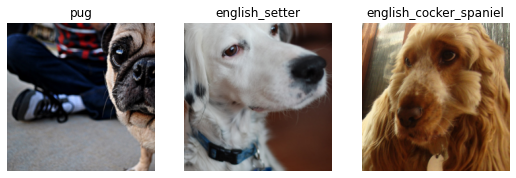

In [37]:
dls.show_batch(nrows=1, ncols=3)

In [38]:
# To debug mistakes while building your DataBlock, use the 'summary' method
# to log the output and narrow down the problem
pets.summary(path/'images') # type: ignore

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/mton/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/mton/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


**`--- DEBUG : SUMMARY EXAMPLE ---`**
***

In [9]:
# An example that FAILS because we FORGET to resize the images, and as a result
# end up with images of DIFFERENT sizes and we can NOT BATCH them
pets1 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # type: ignore
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
)


In [10]:
# Summary can help us DEBUG this problem where we FORGET to resize the images :

# Collating items in a batch
# Error! It's not possible to collate your items in a batch
# Could not collate the 0-th members of your tuples because got the following shapes
# torch.Size([3, 500, 375]),torch.Size([3, 333, 500]),torch.Size([3, 352, 500]),torch.Size([3, 500, 354])

# @note : This CELL will FAIL by design 
# pets1.summary(path/'images') # type: ignore

**`--- LEARNERS [X] IMAGE [Y] CATEGORY ---`**
***

Generally it's recommmended to start training as `SOON` as possible, once our 
DATA is set up :
 - independent (x, images) and dependent (y, labels) are setup correctly
 - loss function verified
 - augmented for batching

In [39]:
# @audit-issue ❌ : fastai.vision.learner FAILS, use fastai.vision.all instead
# to fastai.vision.learner
from fastai.vision.all import vision_learner, error_rate
from fastai.vision.models import resnet34

# @audit-ok 🔎 : Explain metrics=error_rate
# fastai library includes a metric called error_rate that is used to measure 
# the accuracy of a model. This metric is a combination of accuracy and 
# error rate and is calculated by taking the average of true positives, 
# false negatives, false positives, and true negatives. The error rate metric 
# is used to compare the accuracy of different models and measure how well 
# they perform on a given dataset
# I still don't FULLY understand and can't INTERNALIZE this concept yet LOL
learn = vision_learner(dls, arch=resnet34, metrics=error_rate)
# Loss is whatever function we are using to train the parameters of our model
# We haven't chosen a loss function here, so what is fastai using for loss
# @note 🧠 fastai uses a default function based on the DATA and MODEL we are using
# In this case we have IMAGE data and CATEGORICAL outcomes, so fastai will use
# Cross Entropy Loss by default
# @note ⚠️ : learn.fine_tune ~ 25 minutes
learn.fine_tune(2)

#### [ --- FINAL LAYER ACTIVATION --- ]

**`--- LOSS FUNCTION [CROSS ENTROPY] ---`**
***
Cross Entropy Loss are a good `DEFAULT` :
 1) When our `DEPENDENT` variable output are from > 2 CATEGORIES ...
 2) But the output is only `ONE` label ...
 3) Use [BINARY Cross Entropy] (next chapter) for when OUTPUT can be MULTI-label

In [ ]:
# Let's step through and to see what's happening under the hood for a batch 
# with cross entropy by VIEWING our ACTIVATION and LABELS

# one_batch() returns a REAL batch of data from DataLoader as mini-batches :
# @note 🧠 [x] = TensorImage torch.Size([3, 224, 224])
# @note 🧠 [y] = TensorCategory torch.Size([64]]) with integer bewtween 0 and 36
#       to categorize the 37 possible pet breeds
x,y = dls.one_batch()
# @audit-ok ☑ : Explain howcome one_batch() returns batch size of 64
# ANSWER : A batch size of 64 is a good size to use when training 
# a neural network, as it allows the network to take advantage of 
# - parallelization and process the data quickly 
# - Additionally, the batch size of 64 is large enough that the model can learn 
#   from the data and small enough that it is not too computationally expensive 
#   to process the data
print(f'--- [x] is independent variable => [TensorImage]    shape [{x[0].shape}] --- \n')
print(f'--- [y] is dependent   variable => [TensorCategory] shape [{y.shape}] --- \n\n{y}')

--- [x] is independent variable => [TensorImage]    shape [torch.Size([3, 224, 224])] --- 

--- [y] is dependent   variable => [TensorCategory] shape [torch.Size([64])] --- 

TensorCategory([18,  1, 11,  8,  1, 18, 31, 26,  3, 30,  0,  9, 16, 32, 36, 26,
                 2, 23, 11,  7, 21, 22, 16,  9, 32,  3, 29, 21,  4, 36,  1, 14,
                19, 23, 26, 10,  7, 29, 35, 25, 22, 30, 26,  4, 18, 32, 29,  0,
                 8,  6,  3, 17, 10,  3, 17,  5, 36,  5,  2, 21, 16, 19, 17, 23])


In [ ]:
# @audit-issue ❌ : WHY IS THIS NOT LOGGING?? (divided into ^ cell as workaround)
print("Why AM I NOT LOGGING HERE????")
# view predictions (activations of the final layer of our neural network)
# get_preds() takes in an iterator of batches or dataset index (0 = train, 1=valid)
# and returns a tuple of predictions and targets
# - we are feeding in a single batch of data
# - we already have targets, so we ignore the 2nd return value by assigning it 
#   to the special variable._
# @note 🧠 [preds] = TensorBase => [torch.Size([37])] for 37 possible pet breeds
# @audit-ok 🔎 : Explain TensorBase and how it relates to TensorImage and TensorCategory
# TensorBase is a base class for tensors in the torch library. It is the 
# parent class for tensors such as TensorImage and TensorCategory, which are 
# specific tensor types used to store images and categories. TensorBase 
# provides basic methods, such as getitem, len and repr, which are used to 
# access, query and display the data stored in the tensors. As such, 
# TensorBase forms the foundation for the other tensor types, and is essential 
# for working with images and categories in the torch library
# @note ⚠️ : learn.get_preds() ~ 3.3 seconds
preds,_ = learn.get_preds(dl=[(x,y)]) # type: ignore
print(f'---[predictions] TensorBase shape => [{preds[0].shape}]---\n\n{preds[0]}\n')
# The actual predictions are 37 probabilities that sum to 1.0f
print(f'# verify that predictions length [{len(preds[0])}] sum to 1.0f => [{preds[0].sum()}]')

---[predictions] TensorBase shape => [torch.Size([37])]---

TensorBase([7.5418e-09, 1.3944e-06, 6.1215e-08, 8.4531e-07, 9.1124e-09,
            1.8137e-06, 1.5168e-06, 1.0271e-06, 6.0246e-08, 3.4161e-08,
            9.2545e-08, 1.8686e-08, 6.9195e-08, 1.4295e-08, 1.6117e-06,
            9.3220e-08, 1.2571e-07, 7.5013e-08, 9.9781e-01, 2.0784e-03,
            6.9390e-07, 1.0785e-06, 7.6365e-05, 2.8934e-07, 1.0143e-06,
            3.6121e-07, 1.9684e-07, 4.8125e-06, 1.9122e-07, 8.9301e-08,
            7.6570e-07, 1.2926e-06, 1.3114e-05, 2.1093e-08, 6.3789e-08,
            2.9308e-08, 5.6124e-07])

# verify that predictions length [37] sum to 1.0f => [0.9999999403953552]


**`--- [1/2] [SOFTMAX] ---`**

***
SOFTMAX is [1/2] of CROSS ENTROPY LOSS
***

SOFTMAX is a good `ACTIVATION` function in the `FINAL` layer of a `CLASSIFCATION`    
model because they ensure that activations are :

- `between 0 and 1`
- and `sum up to 1`

What does the `SOFTMAX` function do in `PRACTICE`?
 - Taking the exponential ensures all our numbers are positive
 - Dividing the sum ensures all the numbers add up to 1.0f  
 Intuitively the softmax function `REALLY` wants to pick one class among  
 others, because exponential `AMPLIFIES` any slight relative `DIFFERENCES`  
 - This makes it suitable for using as a `PROBABILITY DISTRIBUTION`, and even  
 practical for binary classification (2) instead of SIGMOID for consistency

***
Summarize the difference between `SOFTMAX` and `SIGMOID`

`ANSWER` : The difference is :
 - Sigmoid is used as an activation function in the hidden layers of   
   neural networks to transform the inputs into outputs between 0 and 1 
 - Softmax, on the other hand, is used to provide the probability distribution   
   of a given set of classes in the input. When using softmax, increasing the   
   probability of one class will decrease the total probability of all other   
   classes, as they must sum to 1. 
 - Additionally, softmax is more stable than sigmoid, and can handle a wide   
   range of inputs (more than > 2)
***
Explain when would it make sense to use `SIGMOID` instead of `SOFTMAX`

`ANSWER` : Softmax is fit for training classifiers when : 
 - we KNOW there's a DEFINITIVE label for each input
 - but at inference STRUGGLES when NO recognizable trained label is found, it  
   will ERRONEOUSLY pick whatever HAPPENSTANCE label with a SLIGHTLY higher   
   activation
 - In this ^ case training a SIGMOID activation using multiple binary output  
   columns may yield better results
***


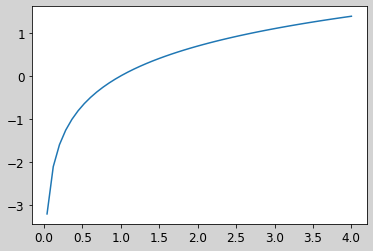

In [ ]:
from fastai.vision.core import torch
from fastbook import plot_function

# @audit 📊 : change background color of matplotlib plots
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'lightgrey'


# Sigmoid when applied to a single column of activations, will yield a column
# of values between 0 and 1
# But if we have MORE > 2 categories in our target (37 pet breeds in this case),
# @note 🧠 : we need an ACITVATION per CATEGORY as oppposed a SINGLE column
plot_function(torch.sigmoid, min=-4, max=4)

In [ ]:
# So we need something MORE than SIGMOID
# Let's start with a simpler 2 category (3s and 7s) example (as opposed to the 
# 37 breeds) to better understand what's going on
# A good first step towards creating the more GENERAL approach :

# For this toy example we assume 6 images and 2 categories : 3s and 7s
acts = torch.randn((6,2))*2 # multiply by 2 = standard deviation of 2 
# random numbers with a standard deviation of 2
# @audit-ok ☑ : Explain why we are using a standard deviation of 2 to generate 
# random numbers
# ANSWER : The standard deviation of 2 is used when generating random numbers 
# to ensure that the data is spread out and not clustered in one area. 
# By using a standard deviation of 2, it allows for more randomness in the 
# generated numbers and prevents any patterns from forming. This is important 
# for ensuring that the generated data is useful and accurate. Additionally, 
# a standard deviation of 2 also helps to ensure that the data follows the 
# normal distribution and that the generated numbers are distributed in a more 
# natural and expected way.
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
# We want the probability of being a 3 plus the probability of being a 7 to add
# up to 1.0f ... @audit 🛑 ... is this true?
# @note 🧠 : applying SIGMOID directly does NOT add up to 1.0f, this doesn't work
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
# @note 🧠 : pandas can be used to display the data in a tabular format!
import pandas as pd

# To reframe 3 or 7 binary activation to serve as a more general classifier, we
# will go from applying SIGMOID() to 2 columns to just ONE column of DIFFERENCE
# between ACTIVATION values for 3 and 7
# - This will let us handle an arbitrary number of categories

# Let's walk through why this works ...
data = []
for i in range(len(acts)):
    # @audit-ok ☑ : So what does the value of a pair of activations represent?
    # Answer : A single pair of activations simply indicate the relative 
    # difference confidence whether the input is a 3 or a 7
    # - So the overall value does NOT MATTER, whether they SUM to be HIGH or LOW
    # - What MATTERS is the RELATIVE DIFFERENCE between the two values : WHICH is 
    #   HIGHER and BY HOW MUCH
    difference_row = acts[i][0] - acts[i][1]
    # sigmoid() NORMALIZES the DIFFERENCE between the two values to 0 and 1
    difference_sigmoid = difference_row.sigmoid()
    # if sigmoid() of the difference is > 0.5 :
    # - The LARGER the difference, the more confidence that the input is a 3
    # - The SMALLER the difference, the more confidence that the input is a 7
    is_three = difference_sigmoid > 0.5
    data.append([
        acts[i][0].tolist(), # 3 raw activation
        acts[i][1].tolist(), # 7 raw activation
        difference_row.tolist(),
        # manually subtract from one to get 7 probability since it's normalized
        difference_sigmoid.tolist(), # 3 probability 
        is_three.tolist()
    ])

# @audit 🖶 -- Verify that SIGMOID() is applied to the DIFFERENCE between values
pd.DataFrame(data, columns=['3', '7', 'DIFFERENCE', 'SIGMOID', 'IS_THREE'])

,3,7,DIFFERENCE,SIGMOID,IS_THREE
0,0.673381,0.257619,0.415762,0.602469,True
1,0.468925,0.460666,0.008259,0.502065,True
2,-2.245713,-0.372657,-1.873056,0.133188,False
3,4.416403,-1.275994,5.692397,0.996640,True
4,0.923314,0.534702,0.388613,0.595949,True
5,1.069809,1.618714,-0.548905,0.366118,False


In [ ]:
# from math import exp
# Now we need to make this work for more than 2 columns/categories (three/seven)
# @note 🧠 : Softmax is the multi-category extension to sigmoid, applicable when: 
# - categories > 2  
# - AND the probability of each category should sum to 1.0f
def softmax(x):
    # exp = exponential function
    # defined as e**x, where is is approximately 2.718
    # this is the inverse of the natural logarithm function 
    # exp is always positive and increases VERY rapidly
    # @audit-ok 🔎 : Explain why we are using the exponentential function
    return exp(x)/exp(x).sum(dim=1, keepdim=True) # type: ignore

In [ ]:
# @audit 🛑 : This errors out FIX IT!
# sm_acts = softmax(acts)
sm_acts = torch.softmax(acts, dim=1)
data = []
for i in range(len(sm_acts)):
    # recalculating the sigmoid of the difference between the 3/7 columns
    difference_sigmoid = (acts[i][0] - acts[i][1]).sigmoid()
    data.append([
        sm_acts[i][0].tolist(), # 3 softmax activation
        # YAaaay! Softmax calculates this for us
        sm_acts[i][1].tolist(), # 7 softmax activation
        difference_sigmoid.tolist()
    ])

# @audit 🖶 : Verify that SOFTMAX returns same value as SIGMOID for 2 categories
# where both columns/categories sum to 1.0f
pd.DataFrame(data, columns=['SOFTMAX_3', 'SOFTMAX_7', 'SIGMOID'])
#sm_acts

,SOFTMAX_3,SOFTMAX_7,SIGMOID
0,0.602469,0.397531,0.602469
1,0.502065,0.497935,0.502065
2,0.133188,0.866811,0.133188
3,0.996640,0.003360,0.996640
4,0.595949,0.404051,0.595949
5,0.366118,0.633882,0.366118


**`--- [2/2] [LOG LIKELIHOOD] ---`**
***
LOG LIKELIHOOD is [2/2] of CROSS ENTROPY LOSS
***

 `CROSS ENTROPY` Loss :
 - SOFTMAX is the first part
 - LOG LIKELIHOOD is the second part

Just as we moved from sigmoid to softmax, we need to extend the loss function to  
work with more than just binary classification :
- Our `ACTIVATIONS` after SOFTMAX are between `0 and 1` summed to 1 for each row
- Our `TARGETS` are integers between `0 and 36` (37 breed)



In [ ]:
from fastai.vision.data import tensor

# Log Likelihood
# @note 🧠 : targ is the HEADER for the LOSS/performance of a specific LABEL
# - targ is 0, then LOSS = performance of our model in predicting 3
# - targ is 1, then LOSS = performance of our model in predicting 7
targ = tensor([0,1,0,1,1,0])
idx = range(6)

# We are picking the loss from the column containing the correct label
# And implicitly since all the columns sum to 1.0f because of softmax,
# when we push the activation for the correct label as HIGH as possible
# we are also decreasing the activations for the remaining columns
# This works for binary/2-catagories (3,7) but scales to N categories (0-9)
loss = sm_acts[idx, targ]

data = []
for i in range(len(sm_acts)):
    row_target = targ[i].tolist() #[0]=>(3) or [1]=>(7)
    if row_target == 0:
        row_label = '--[3]--'
    else:
        row_label = '--[7]--'
    data.append([
        sm_acts[i][0].tolist(), #3 softmax activation
        sm_acts[i][1].tolist(), #7 softmax activation
        # HEADER => picks the LABEL to lookup the LOSS for
        row_target, 
        # based on targ HEADER, picks the loss (softmax), if :
        # - targ is 0, then LOSS = performance of our model in predicting 3
        # - targ is 1, then LOSS = performance of our model in predicting 7
        loss[i].tolist(),
        row_label
    ])

# sm_acts[idx, targ] visualized as a table, we can see that :
# - the LOSS column is the result of using `idx`` and `targ`` to lookup `sm_acts`
#   two-column matrix/tensor
# - this LOSS lookup can scale to N categories by using the 'targ' tensor
# @note 🧠 : This is how we move beyond training only 3/7 to all 0-9 digits by :
# - Expand `targ`` to be a tensor of all 0-9 digits
# - 'targ' LOOKS UP the COLUMN containing the SPECIFIC label
# - SOFTMAX REDUCES the OTHER labels by AMPLIFYING the ONE label, no need to 
#   worry about the other labels
# - he LOSS picked by 'targ' will CAPTURE how WELL we are PREDICTING
#   each digit!  Because SOFTMAX ensures that each ACTIVATION sums to 1.0f
# @audit 🖶 : Verify that our loss and target are correct
pd.DataFrame(data, columns=['3_ACTIVATION', '7_ACTIVATION', 'TARGET', 'LOSS_RESULT', 'TARGET_LABEL'])

,3_ACTIVATION,7_ACTIVATION,TARGET,LOSS_RESULT,TARGET_LABEL
0,0.602469,0.397531,0,0.602469,--[3]--
1,0.502065,0.497935,1,0.497935,--[7]--
2,0.133188,0.866811,0,0.133188,--[3]--
3,0.996640,0.003360,1,0.003360,--[7]--
4,0.595949,0.404051,1,0.404051,--[7]--
5,0.366118,0.633882,0,0.366118,--[3]--


**`--- NEGATIVE LOG LIKELIHOOD ---`**

In [ ]:
from fastai.vision.data import F

# nll is taking the MEANS of the positive OR negative (depending on whether it's
# our correct or incorrect class) log of our PROBABILITIES :
# @audit 🛑 : Explain positive/negative log of probabilities and correct/incorrect
# class -- WHAT AM I MISSING HERE?
# - NEGATIVE
# - LOG
# - LIKELIHOOD
# @note 🧠 : nll_loss (negative LOG LIKELIHOOD loss) is the built-in pytorch
# @note ⚠️ : DESPITE having LOG in the name, this Pytorch function does NOT 
# apply the LOG :
# - it ASSUMES you have ALREADY applied the LOG to your INPUTS
# @note 🧠 : reduction='none' means that the loss is NOT averaged across the
# batch (returning a SCALAR) but instead returns a TENSOR of the same size as
# the INPUT (sm_acts)
# function EQUIVALENT to our manual loss calculation above : sm_acts[idx, targ]?
nll_loss_tensor = F.nll_loss(sm_acts, targ, reduction='none')

# @audit-ok 🔎 : Explain how nll_loss applies the log afterwards, so the output 
# values will be negative
sm_acts_tensor = -sm_acts[idx, targ]

data = []
for i in range(len(nll_loss_tensor)):
    # @audit-ok 🔎 : Is there a way to transpose the nll_loss and sm_acts tensors
    # instead of rebuilding the table one row at a time?
    row = [
        nll_loss_tensor[i].tolist(), 
        sm_acts_tensor[i].tolist()
    ]
    data.append(row)
# @audit 🖶 : Verify that our manual and builtin loss calculations are the same
pd.DataFrame(data, columns=['NLL_LOSS', '(-)SM_ACTS'])

,NLL_LOSS,(-)SM_ACTS
0,-0.602469,-0.602469
1,-0.497935,-0.497935
2,-0.133188,-0.133188
3,-0.003360,-0.003360
4,-0.404051,-0.404051
5,-0.366118,-0.366118


**`--- LOG : log(a*b) = log(a) + log(b) ---`**

***
`LOG` - logarithm increases `LINEARLY` while the underlying signal increases `EXPONENTIALLY`
***

LOG is a KEY concept heavily utilized in machine learning :
- log(a*b) = log(a) + log(b)
- Computer Scientists love using logarithm because of it's `LINEAR` scale allows  
  replacing `MULTIPLICATION` with `ADDITION` => handling `EXPONENTIAL` large or  
  small magnifies the compute `ERROR`

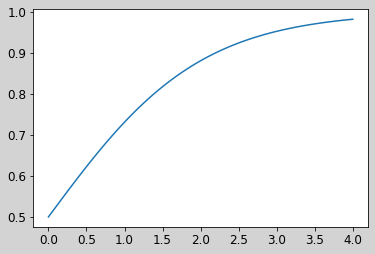

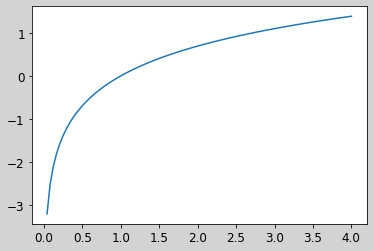

In [ ]:
# @audit-ok 🔎 : Explain why Taking the LOG of the LOSS improves PERFORMANCE
# ANSWER : SOFTMAX returns a value between 0.0f and 1.0f :
# - Logarithm OFFSETS the MAGNITUDE of Softmax's DIFFERENCE because it increases
#   LINEARLY while the underlying values increase EXPONENTIALLY
# - Else the DIFFERENCE would be between 0.999 and 0.99 is 10x more confidence
# - Negative Infinity to 0 on the other hand will NORMALIZE that ^ MAGNITUDE

# pre log applied
plot_function(torch.sigmoid, min=0, max=4)

# torch.log is the natural logarithm function and supports this MAGNITUDE diff
# The logarithm function has this identity:
# - y = b^a
# - a = log(y, b)
# - we want to ASSUME that log(y, b) returns log y base b
# However, log in Python uses the special number (2.718...) as the base

# post log applied
# @audit 🛑 : What EXACTLY are we doing : LOG to unbend the SIGMOID to a LINEAR curve?
plot_function(torch.log, min=0, max=4)

In [ ]:
from fastai.vision.core import nn

# @note 🧠 The order of operations for CROSS ENTROPY LOSS is :
# - SOFTMAX (exponential curve)
# - apply LOG (linearlize) (log_softmax is the Pytorch function for these 2 steps)
# - NLL_LOSS
# @note 🧠 nn.CrossEntropyLoss() is the Pytorch function tfor 3 steps above

# In pytorch this is available as an nn.CrossEntropyLoss() CLASS form
# But it's also available as a PLAIN function form : 
# - F.cross_entropy(acts, targ)
# - DEFAULT is to use the CLASS form to match Pytorch's OFFICIAL docs
loss_func = nn.CrossEntropyLoss()

# By DEFAULT crossentropy loss function takes the "MEANS" of each loss item
cross_entropy_means = loss_func(acts, targ)

# But we can use reduction='none' to disable that
cross_entropy_none = nn.CrossEntropyLoss(reduction='none')(acts, targ)

# MANUALLY apply LOG nll_loss to nll_loss_tensor 
# also flip the sign since negative EXPONENTS return NaN
# @audit 🛑 : I don't UNDERSTAND log ... TRADE IN IGNORANCE and VERIFY lol
nll_loss_log = torch.log(-nll_loss_tensor) * -1

print(f'--- [CROSS ENTROPY LOSS REDUCTION=TRUE] ---\n# order of operations MATTER ')
print(f'- [{cross_entropy_means:7.4f}] # -YES- : (1) nn.CrossEntropyLoss (log)  => (2) means ')
print(f'- [{nll_loss_log.mean():7.4f}] # -YES- : (1) nll_loss => (2) log        => (3) means ')
print(f'- [{-torch.log(-nll_loss_tensor.mean()):7.4f}] # -NOO- : (1) nll_loss => (2) means      => (3) log\n')
print(f'--- [CROSS ENTROPY REDUCTION NONE] ---\n{cross_entropy_none}\n')

data = []
for i in range(len(cross_entropy_none)):
    row = [
        cross_entropy_none[i].tolist(),
        nll_loss_log[i].tolist(),
        nll_loss_tensor[i].tolist()
    ]
    data.append(row)

# @audit 🖶 : Compare NLL_LOSS to MEANS_LOSS (after applying LOG)
pd.DataFrame(data, columns=['CROSS ENTROPY LOSS', '-LOG(-NLL_LOSS)', 'NLL_LOSS'])

--- [CROSS ENTROPY LOSS REDUCTION=TRUE] ---
# order of operations MATTER 
- [ 1.8045] # -YES- : (1) nn.CrossEntropyLoss (log)  => (2) means 
- [ 1.8045] # -YES- : (1) nll_loss => (2) log        => (3) means 
- [ 1.0951] # -NOO- : (1) nll_loss => (2) means      => (3) log

--- [CROSS ENTROPY REDUCTION NONE] ---
tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])



,CROSS ENTROPY LOSS,-LOG(-NLL_LOSS),NLL_LOSS
0,0.506720,0.506720,-0.602469
1,0.697285,0.697285,-0.497935
2,2.015990,2.015990,-0.133188
3,5.695763,5.695763,-0.003360
4,0.906213,0.906213,-0.404051
5,1.004798,1.004798,-0.366118


**`--- CROSS ENTROPY GRADIENTS ---`**

- The gradient of `cross_entropy(a,b)` is `softmax(a)-b`
- Since `softmax(a)` is the FINAL ACTIVATION of the model, the gradient is  
proportional to the DIFFERENCE between the prediction and the target

#### [ --- MODEL INTERPRETATION --- ]

In [ ]:
from fastai.vision.learner import ClassificationInterpretation

# @note ⚠️ : ClassificationInterpretation.from_learner() ~ 1.5 minutes
interp = ClassificationInterpretation.from_learner(learn)

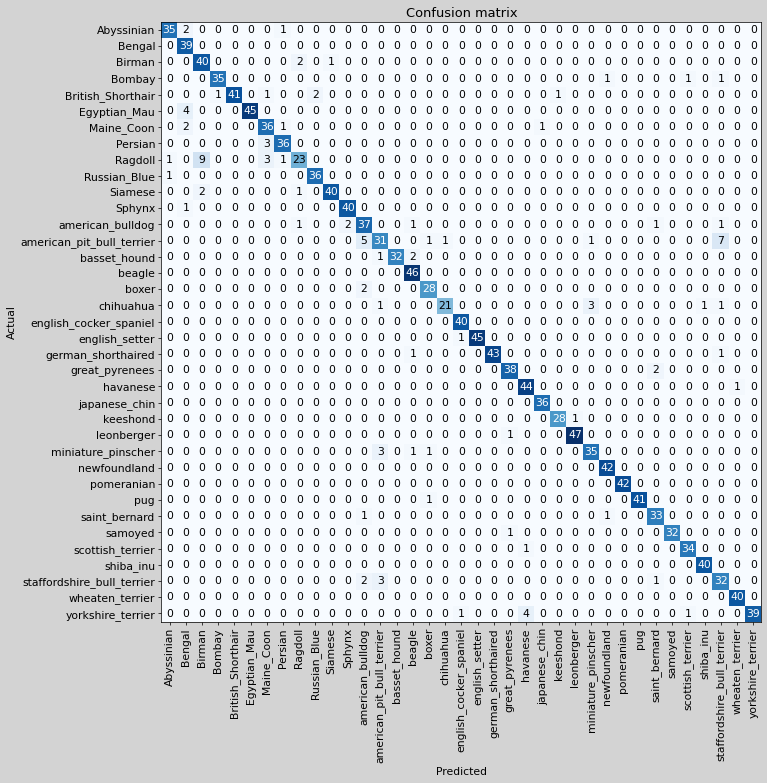

In [ ]:
# @audit 📊 : change background color of matplotlib plots
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'lightgrey'

# @note ⚠️ : interp.plot_confusion_matrix() ~ 1.5 minutes
interp.plot_confusion_matrix(figsize=(12,12), dpi=65)

##### **` --- TRANSFER LEARNING --- `**

In [ ]:
# log the cells of the confusion matrix with the most ERRORS (min 5 or more)
# @note ⚠️ : interp.most_confused() ~ 1.5 minutes
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('american_pit_bull_terrier', 'american_bulldog', 5)]

--- Learning Rate Finder ---

If our learning RATE is too LOW :  
- training can be time/energy INTRACTABLE, too many epochs to reach performance
- risk of MEMORIZATION or OVERFIT of training data and FAILS to GENERALIZE

If our learning RATE is too HIGH :
- OVERSHOOT targets and infinite bounce LOOP

In [12]:


learn = vision_learner(dls, resnet34, metrics=error_rate)
# We are INLINE guessing a learning rate of 0.1, which is likely too HIGH
# @audit 🛑 : WHY does this NOT print out EPOCH result table like the BOOK?
# @note ⚠️ : learn.fine_tune() ~ 27 minutes
learn.fine_tune(1, base_lr=0.1)

In [48]:
from fastai.callback.progress import ProgressCallback
learn.add_cb(ProgressCallback())
learn.to_fp16()

learn.fine_tune(1)

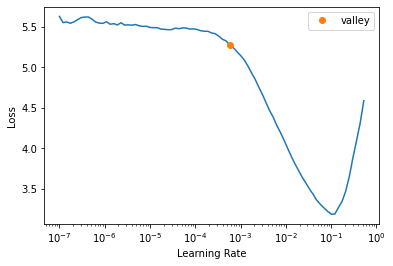

In [13]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
# Here we are using the LR FINDER to find the BEST learning rate
# @note ⚠️ : learn.lr_find() ~ 16 minutes
lr_min = learn.lr_find()

In [28]:
learn.fine_tune??
print(f'Minimum/10: {lr_min.valley:2e}, steepest point: {lr_min.valley:2e}')

Minimum/10: 5.754399e-04, steepest point: 5.754399e-04


Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/fastai/callback/schedule.py
Type:      method


In [40]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
# @note ⚠️ : learn.fine_tune() ~ 50 minutes
learn.fine_tune(2, base_lr=lr_min.valley)

In [32]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
# @note ⚠️ : learn.fit_one_cycle() ~ 50 minutes
learn.fit_one_cycle(3, 3e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

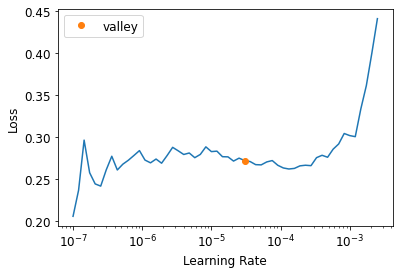

In [ ]:
# Because we have weights that are already trained, and more layers to train
# the model has changed enough where we need to check our learning rate again
# Likely we will need to use a lower learning rate
learn.lr_find()

In [ ]:
learn.lr_find??

Signature:
learn.lr_find(
    start_lr=1e-07,
    end_lr=10,
    num_it=100,
    stop_div=True,
    show_plot=True,
    suggest_funcs=<function valley at 0x169dc98b0>,
)
Source:   
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggest_funcs=(SuggestionMethod.Valley)):
    "Launch a mock training to find a good learning rate and return suggestions based on `suggest_funcs` as a named tuple"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if suggest_funcs is not None:
        lrs, losses = tensor(self.recorder.lrs[num_it//10:-5]), tensor(self.recorder.losses[num_it//10:-5])
        nan_idxs = torch.nonzero(torch.isnan(losses.view(-1)))
        if len(nan_idxs) > 0:
            drop_idx = min(nan_idxs)
            lrs = lrs[:drop_idx]
            losses = losses[:drop_idx]
        _suggestions, nm

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.807385,2.346710,0.627876,13:42
1,2.761513,2.855053,0.615020,13:27
2,2.694891,14.671639,0.604195,12:44
3,2.572668,2.296487,0.590663,12:32
4,2.584789,2.583465,0.594723,12:34
5,2.585968,3.252128,0.591340,12:36


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.180836,0.345385,0.101489,10:44
1,0.534204,0.252715,0.080514,10:21
2,0.331744,0.219855,0.068336,10:17


epoch,train_loss,valid_loss,error_rate,time
0,0.265986,0.212265,0.066982,12:54
1,0.256798,0.206923,0.069012,13:18
2,0.238853,0.205375,0.067659,13:00
3,0.229449,0.199506,0.065629,12:52
4,0.200070,0.194700,0.057510,12:55
5,0.181759,0.196889,0.064953,12:54
6,0.148528,0.188072,0.055480,12:54
7,0.157825,0.187674,0.055480,12:35
8,0.137463,0.188838,0.056834,12:36
9,0.139100,0.188969,0.058187,12:51


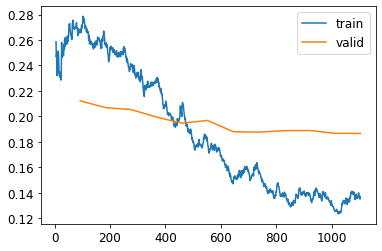

In [ ]:
learn.recorder.plot_loss()

In [ ]:
from fastai.callback.fp16 import *
from fastai.vision.models import resnet50
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,1.286211,0.266255,0.083221,23:56
1,0.594020,0.288783,0.093369,23:34
2,0.402422,0.294151,0.089986,24:51


epoch,train_loss,valid_loss,error_rate,time
0,0.270663,0.213406,0.072395,32:03
1,0.310084,0.337039,0.106901,26:31
2,0.263010,0.259290,0.080514,26:37
3,0.145033,0.202008,0.054804,30:54
4,0.088044,0.181623,0.048038,32:03
5,0.057410,0.178267,0.047361,27:09
